In [5]:
import json
import pandas as pd
import numpy as np
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import emoji
from textblob import TextBlob
from fuzzywuzzy import process
import matplotlib.pyplot as plt
from wordcloud import WordCloud


nltk.download('vader_lexicon')

/home/kprasath/anaconda3/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/kprasath/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Getting the Data

In [2]:
#crime data
crime_data = pd.read_csv('crime_data.csv')
crime_data.head()

a40_abduction_and_related_offences   b30_burglary_break_and_enter  \
0                                 1.0                             27   
1                                 0.0                             69   
2                                21.0                            983   
3                                 9.0                            832   
4                                 0.0                            205   

    a10_homicide_and_related_offences  \
0                                 0.0   
1                                 0.0   
2                                 4.0   
3                                 4.0   
4                                 2.0   

    f30_other_government_regulatory_offences   lga_code11  \
0                                        1.0        20110   
1                                        1.0        20260   
2                                        1.0        20570   
3                                        1.0        20660   
4                                        2.0        20740   

    total_division_c_offences   a30_sexual_offences  \
0                          53                    95   
1                         137                    58   
2                         414                   345   
3                         513                   185   
4                         154                    74   

    a70_stalking_harassment_and_threatening_behaviour  \
0                                                 11    
1                                                 38    
2                                                236    
3                                                266    
4                                                119    

    e10_justice_procedures   total_division_f_offences  ...  \
0                       11                           1  ...   
1                       84                           2  ...   
2                      376                          23  ...   
3                      192                          13  ...   
4                       48                           5  ...   

    total_division_e_offences   e20_breaches_of_orders  \
0                          68                       57   
1                         411                      327   
2                        1884                     1508   
3                        2038                     1846   
4                         378                      330   

    f10_regulatory_driving_offences   a60_blackmail_and_extortion   b40_theft  \
0                               0.0                           0.0          90   
1                               0.0                           5.0         222   
2                               0.0                           7.0        3501   
3                               0.0                           4.0        2931   
4                               0.0                           2.0         640   

    c90_other_drug_offences   f20_transport_regulation_offences  \
0                       0.0                                 0.0   
1                       0.0                                 0.0   
2                       5.0                                 4.0   
3                       1.0                                 3.0   
4                       1.0                                 2.0   

    a20_assault_and_related_offences   b60_bribery  \
0                                 81           0.0   
1                                176           0.0   
2                               1007           0.0   
3                                611           0.0   
4                                277           0.0   

    c10_drug_dealing_and_trafficking  
0                                9.0  
1                               24.0  
2                               68.0  
3                               47.0  
4                               29.0  

[5 rows x 37 columns]

In [4]:
#state data
state_data = pd.read_csv('state_data.csv')
state_data.head()

NameError: name 'pd' is not defined

In [5]:
%%time

#using a bigger data 
with open('smallTwitter.json', 'r') as f:
    data = json.load(f)

filtered_data = []

for tweet in data:
    if 'places' in tweet['includes']:
        for place in tweet['includes']['places']:
            if place['full_name'].endswith(', Victoria'):
                area_name, _, _ = place['full_name'].partition(', ')
                if '-' in area_name:
                    area_name = area_name.split('-')[0].strip()

                filtered_data.append({
                    '_id': tweet['_id'],
                    #'author_id': tweet['data']['author_id'],
                    'text': tweet['data']['text'],
                    'sentiment': tweet['data'].get('sentiment', None),  # returns None if 'sentiment' key doesn't exist
                    'language': tweet['data']['lang'],
                    'area_name': area_name
                })

main_data = pd.DataFrame(filtered_data)

CPU times: user 4.27 s, sys: 1.02 s, total: 5.29 s
Wall time: 5.28 s


In [ ]:
main_data.head()

## Data cleaning and transformation

In [ ]:
print(crime_data.isna().sum())
print(state_data.isna().sum())
print(main_data.isna().sum())

#Only sentiment has missing values,
#but we can ignore for now cuz we will be engineering this variable later

In [ ]:
#Same here
print(crime_data.isnull().sum())
print(state_data.isnull().sum())
print(main_data.isnull().sum())

In [6]:
# Variable Type Adjustments

#For consistency 
crime_data.columns = crime_data.columns.str.strip()
state_data.columns = state_data.columns.str.strip()
main_data.columns = main_data.columns.str.strip()

crime_data['lga_code11'] = crime_data['lga_code11'].astype(int)
state_data['lga_code'] = state_data['lga_code'].astype(int)
main_data['_id'] = main_data['_id'].astype(str)


### Text Cleaning

In [ ]:
main_data[['text']].head(5)

Cleaning the data:

- Remove URLs: Since URLs generally don't contribute to sentiment, we can remove them.
- Remove mentions: Mentions (@username) may or may not contribute to sentiment, but they can be problematic for analysis due to their variability.
- Remove special characters: These generally don't contribute to sentiment and can make analysis more difficult.
- Remove numbers: Numbers don't contribute to sentiment and can be safely removed.
- Convert to lowercase: Case doesn't matter for sentiment, and converting to lowercase can simplify subsequent analysis.
- Remove extra spaces: Cleaning up extra spaces will make the text more consistent for analysis.

Feature extraction:

- Number of hashtags: Hashtags can be indicators of the topic or intensity of a tweet, so we'll count them.
- Number of words: The length of a tweet can be a useful feature.
- Number of characters: This can also be a useful feature.
- Sentiment analysis: We will use NLTK's VADER sentiment analysis tool to compute sentiment scores for each cleaned tweet.

In [ ]:
main_data.language.value_counts()

In [7]:
%%time 

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

def clean_text(text):
    text = re.sub(r'http\S+|www.\S+', '', text)  
    text = re.sub(r'@\w+', '', text)  
    text = re.sub(r'[^A-Za-z\s]', '', text)  
    text = re.sub(r'\d+', '', text)  
    text = re.sub(r'\s{2,}', ' ', text)  
    text = text.lower()  
    return text.strip()  

def extract_features(text):
    num_hashtags = text.count('#')
    num_words = len(text.split())
    num_chars = len(text)
    num_emojis = emoji.emoji_count(text)
    return num_hashtags, num_words, num_chars, num_emojis

def extract_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def get_sentiment_score(text):
    return sia.polarity_scores(text)['compound']

# Filter out the non-English tweets from the main data
main_data = main_data[main_data['language'] == 'en'].copy()

# Apply the cleaning function to the 'text' column
main_data.loc[:, 'cleaned_text'] = main_data['text'].apply(clean_text)

# Apply the feature extraction function to the cleaned text and create new columns
main_data['num_hashtags'], main_data['num_words'], main_data['num_chars'], main_data['num_emojis'] = zip(*main_data['cleaned_text'].map(extract_features))

# Apply sentiment analyzer to get the polarity scores and create a new column for that
main_data['subjectivity'] = main_data['cleaned_text'].apply(extract_subjectivity)

# Add sentiment score
main_data['sentiment_score'] = main_data['cleaned_text'].apply(get_sentiment_score)


main_data.head()

CPU times: user 7.76 s, sys: 3.76 ms, total: 7.76 s
Wall time: 7.76 s


_id                                               text  \
0  1414031972041588744  Stella is spending the day with her cousin Mon...   
1  1414032158197354497  @eleaud Oh no! I hope they don’t go up any fur...   
2  1414036352308445186  Sunday @afl R17: #aflgiantssuns #afldogsswans ...   
3  1414044890040733699  @BlancheVerlie Sorry to watch the declining si...   
4  1414057294950649861  @VicGovAu One lady had over 40 saved photos of...   

   sentiment language    area_name  \
0   0.000000       en  Ocean Grove   
1   0.090909       en  Ocean Grove   
2   0.000000       en     Drysdale   
3   0.058824       en  Ocean Grove   
4   0.090909       en     Drysdale   

                                        cleaned_text  num_hashtags  num_words  \
0   stella is spending the day with her cousin monty             0          9   
1           oh no i hope they dont go up any further             0         10   
2  sunday r aflgiantssuns afldogsswans afltigerspies             0          5   
3  sorry to watch the declining situation up ther...             0         33   
4  one lady had over saved photos of login cube s...             0         20   

   num_chars  num_emojis  subjectivity  sentiment_score  
0         48           0           0.0           0.0000  
1         40           0           0.5           0.1779  
2         49           0           0.0           0.0000  
3        166           0           0.5           0.7717  
4         99           0           0.5           0.4215

In [7]:
text_data = main_data.drop(['_id', 'text', 'sentiment', 'language'], axis=1)
text_data.head()

area_name                                       cleaned_text  \
0  Ocean Grove   stella is spending the day with her cousin monty   
1  Ocean Grove           oh no i hope they dont go up any further   
2     Drysdale  sunday r aflgiantssuns afldogsswans afltigerspies   
3  Ocean Grove  sorry to watch the declining situation up ther...   
4     Drysdale  one lady had over saved photos of login cube s...   

   num_hashtags  num_words  num_chars  num_emojis  subjectivity  \
0             0          9         48           0           0.0   
1             0         10         40           0           0.5   
2             0          5         49           0           0.0   
3             0         33        166           0           0.5   
4             0         20         99           0           0.5   

   sentiment_score  
0           0.0000  
1           0.1779  
2           0.0000  
3           0.7717  
4           0.4215

In [2]:
state_data.dtypes

NameError: name 'state_data' is not defined

In [3]:
state_data.head()

NameError: name 'state_data' is not defined

In [8]:
crime_data.head()

a40_abduction_and_related_offences  b30_burglary_break_and_enter  \
0                                 1.0                            27   
1                                 0.0                            69   
2                                21.0                           983   
3                                 9.0                           832   
4                                 0.0                           205   

   a10_homicide_and_related_offences  \
0                                0.0   
1                                0.0   
2                                4.0   
3                                4.0   
4                                2.0   

   f30_other_government_regulatory_offences  lga_code11  \
0                                       1.0       20110   
1                                       1.0       20260   
2                                       1.0       20570   
3                                       1.0       20660   
4                                       2.0       20740   

   total_division_c_offences  a30_sexual_offences  \
0                         53                   95   
1                        137                   58   
2                        414                  345   
3                        513                  185   
4                        154                   74   

   a70_stalking_harassment_and_threatening_behaviour  e10_justice_procedures  \
0                                                 11                      11   
1                                                 38                      84   
2                                                236                     376   
3                                                266                     192   
4                                                119                      48   

   total_division_f_offences  ...  total_division_e_offences  \
0                          1  ...                         68   
1                          2  ...                        411   
2                         23  ...                       1884   
3                         13  ...                       2038   
4                          5  ...                        378   

   e20_breaches_of_orders  f10_regulatory_driving_offences  \
0                      57                              0.0   
1                     327                              0.0   
2                    1508                              0.0   
3                    1846                              0.0   
4                     330                              0.0   

   a60_blackmail_and_extortion  b40_theft  c90_other_drug_offences  \
0                          0.0         90                      0.0   
1                          5.0        222                      0.0   
2                          7.0       3501                      5.0   
3                          4.0       2931                      1.0   
4                          2.0        640                      1.0   

   f20_transport_regulation_offences  a20_assault_and_related_offences  \
0                                0.0                                81   
1                                0.0                               176   
2                                4.0                              1007   
3                                3.0                               611   
4                                2.0                               277   

   b60_bribery  c10_drug_dealing_and_trafficking  
0          0.0                               9.0  
1          0.0                              24.0  
2          0.0                              68.0  
3          0.0                              47.0  
4          0.0                              29.0  

[5 rows x 37 columns]

## Data integration & Mapping

In [ ]:
state_data.head()

In [8]:
lga_code_mapping = state_data.set_index('scc_name')['lga_code']

text_data['lga_code'] = text_data['area_name'].map(lga_code_mapping)

state_data_unique = state_data.groupby('lga_code').agg({
    'lga_name': 'first',
    'lat': 'mean',
    'lon': 'mean'
}).reset_index()

text_data = text_data.merge(state_data_unique, on='lga_code', how='left')


In [9]:
text_data.head()

area_name                                       cleaned_text  \
0  Ocean Grove   stella is spending the day with her cousin monty   
1  Ocean Grove           oh no i hope they dont go up any further   
2     Drysdale  sunday r aflgiantssuns afldogsswans afltigerspies   
3  Ocean Grove  sorry to watch the declining situation up ther...   
4     Drysdale  one lady had over saved photos of login cube s...   

   num_hashtags  num_words  num_chars  num_emojis  subjectivity  \
0             0          9         48           0           0.0   
1             0         10         40           0           0.5   
2             0          5         49           0           0.0   
3             0         33        166           0           0.5   
4             0         20         99           0           0.5   

   sentiment_score  lga_code         lga_name        lat         lon  
0           0.0000   22750.0  Greater Geelong -38.145829  144.416254  
1           0.1779   22750.0  Greater Geelong -38.145829  144.416254  
2           0.0000   22750.0  Greater Geelong -38.145829  144.416254  
3           0.7717   22750.0  Greater Geelong -38.145829  144.416254  
4           0.4215   22750.0  Greater Geelong -38.145829  144.416254

In [10]:
#crim data merging

# Assuming crime_data and state_data are your two dataframes
# and 'lga_code' is the name of the column with the LGA code in both dataframes
# and 'lga_code11' is the column name in crime_data

# First, make sure the 'lga_code' columns in both dataframes are of the same type
crime_data['lga_code11'] = crime_data['lga_code11'].astype(str)
state_data['lga_code'] = state_data['lga_code'].astype(str)

# Then, merge the dataframes
merged_data = pd.merge(crime_data, state_data, left_on='lga_code11', right_on='lga_code', how='left')


In [12]:
#merged_data.to_csv('crime_spatial.csv', index=False)

In [10]:
#text_data.to_csv('textdatafor_spatial.csv', index=False)

# Analysis

In [12]:
#text_data[['num_hashtags', 'num_words', 'num_chars', 'new_sentiment', 'num_emojis', 'compound', 'subjectivity']].describe()


KeyError: "['new_sentiment', 'compound'] not in index"

plt.hist(text_data['new_sentiment'], bins=20, alpha=0.5)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution')
plt.show()

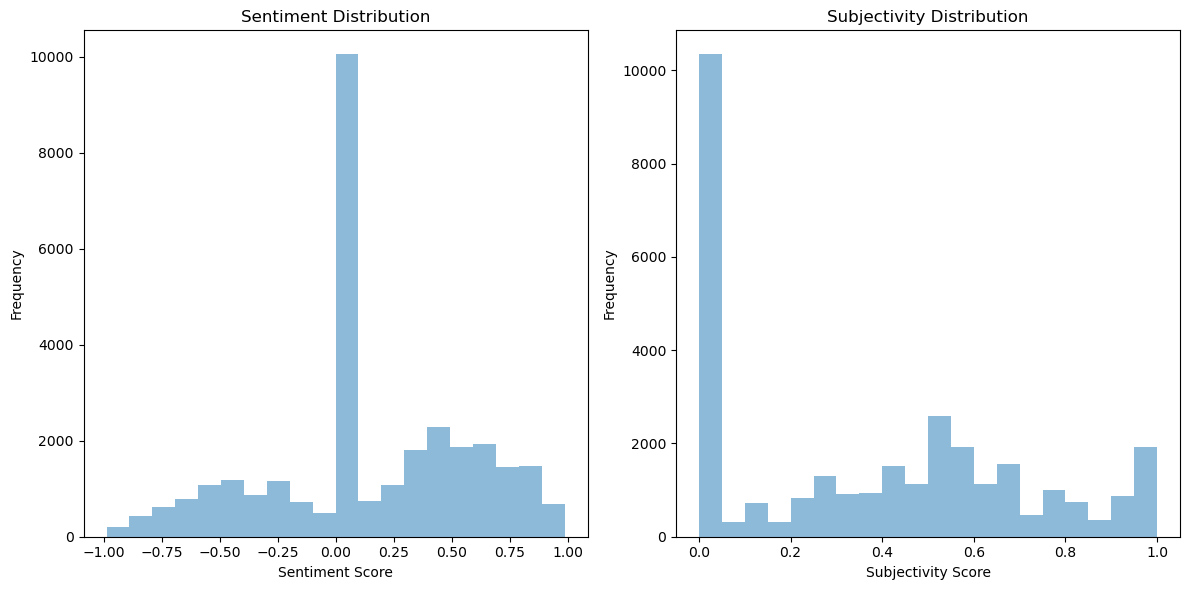

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Sentiment Distribution
axes[0].hist(text_data['sentiment_score'], bins=20, alpha=0.5)
axes[0].set_xlabel('Sentiment Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Sentiment Distribution')

# Plot 2: Subjectivity Distribution
axes[1].hist(text_data['subjectivity'], bins=20, alpha=0.5)
axes[1].set_xlabel('Subjectivity Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Subjectivity Distribution')

plt.tight_layout()
plt.show()

In [ ]:
# takes way too long, wont be scalable in big data
'''from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(' '.join(text_data['cleaned_text']))

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()'''


In [ ]:
#taking a very long time to run

import geopandas as gpd

gdf = gpd.GeoDataFrame(text_data, geometry=gpd.points_from_xy(text_data.lon_x, text_data.lat_x))

fig, ax = plt.subplots()
gdf.plot(ax=ax, color='blue')
plt.show()


In [ ]:
text_data.head()

In [ ]:
!pip3 install geoplot

In [ ]:
%%time
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import pandas as pd
from shapely import wkt

def load_wkt(value):
    if isinstance(value, str):
        return wkt.loads(value)
    return None

text_data['geometry_y'] = text_data['geometry_y'].apply(load_wkt) # convert POLYGON string to geometry
gdf = gpd.GeoDataFrame(text_data, geometry='geometry_y')  # convert DataFrame to GeoDataFrame

# Group by 'scc_name_x' and calculate mean sentiment
gdf['new_sentiment'] = pd.to_numeric(gdf['new_sentiment'], errors='coerce')
grouped_gdf = gdf.groupby('scc_name_x').agg({'new_sentiment': 'mean'})

# Join the original gdf with grouped_gdf to get the mean sentiment for each row
gdf = gdf.merge(grouped_gdf, on='scc_name_x')

# Create a KDE plot and overlay it on a polygon plot
ax = gplt.kdeplot(
    gdf,
    clip=gdf.geometry,
    shade=True,
    cmap='Reds',
    projection=gcrs.AlbersEqualArea(),
)
gplt.polyplot(gdf, ax=ax, zorder=1)


In [ ]:
text_data.head()

In [ ]:
%%time

import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
from shapely.geometry import Point

# Convert lat/lon to a shapely Point object
text_data['geometry'] = text_data.apply(lambda row: Point(row.lon, row.lat), axis=1)

# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(text_data, geometry='geometry')

# Group by 'lga_name' and calculate mean sentiment_score
gdf['sentiment_score'] = pd.to_numeric(gdf['sentiment_score'], errors='coerce')
grouped_gdf = gdf.groupby('lga_name').agg({'sentiment_score': 'mean'})

# Join the original gdf with grouped_gdf to get the mean sentiment for each row
gdf = gdf.merge(grouped_gdf, on='lga_name', suffixes=('', '_mean'))

# Create a KDE plot and overlay it on a polygon plot
ax = gplt.kdeplot(
    gdf,
    hue='sentiment_score_mean',
    clip=gdf.geometry,
    shade=True,
    cmap='coolwarm',
    projection=gcrs.AlbersEqualArea(),
)
gplt.polyplot(gdf, ax=ax, zorder=1)
